In [1]:
import transformers

print("Transformers Version:", transformers.__version__)


Transformers Version: 4.26.1


In [2]:
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()


In [3]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [4]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [5]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        assert model_name in ['PhoBERT', 'BERT4News', 'ViBERT']
        
        self.model_name = model_name
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        
        if model_name == 'PhoBERT':
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        elif model_name == 'BERT4News':
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
        else:
            self.bert = AutoModel.from_pretrained('FPTAI/vibert-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        x = self.drop(output)
        x = self.fc(x)
        return x
    

In [6]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [7]:
import os
import gc
import json
import torch
from torch import nn
import numpy as np
from scipy import interpolate
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []

    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]

        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data[label_column].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())
            
    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            break
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)
    
    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    if len(history['train_loss']) <= 1:
        return False
    
    colors = plt.get_cmap('tab10').colors
    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    
def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()


In [8]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# PhoBERT

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_data(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


## Task 1

In [12]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8381 - Train F1-score: 0.7997 - Train Loss: 0.4083
Valid Accuracy: 0.8823 - Valid F1-score: 0.8237 - Valid Loss: 0.5486
Validation loss decreased (inf --> 0.548585). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8923 - Train F1-score: 0.8642 - Train Loss: 0.3107
Valid Accuracy: 0.8936 - Valid F1-score: 0.8590 - Valid Loss: 0.3572
Validation loss decreased (0.548585 --> 0.357203). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9223 - Train F1-score: 0.9010 - Train Loss: 0.2528
Valid Accuracy: 0.8987 - Valid F1-score: 0.8612 - Valid Loss: 0.4260
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9383 - Train F1-score: 0.9210 - Train Loss: 0.2211
Valid Accuracy: 0.8867 - Valid F1-score: 0.8320 - Valid Loss: 0.8388
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9563 - Train F1-score: 0.9439 - Train Loss: 0.1844
Valid Accuracy: 0.8943 - Valid F1-score: 0.8539 - Valid Loss: 0.6190
EarlyStopping counter: 3 out of 3
Early stopping.


In [13]:
save_visualization_history(history, 'PhoBERT', task=1)
plotting_history(history)


In [14]:
import os
import torch

model_name = "PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8923
Precision: 0.8740
Recall: 0.8417
F1-score: 0.8558
Confusion matrix:
 [[2764  147]
 [ 280  772]]
              precision    recall  f1-score   support

           0     0.9080    0.9495    0.9283      2911
           1     0.8400    0.7338    0.7834      1052

    accuracy                         0.8923      3963
   macro avg     0.8740    0.8417    0.8558      3963
weighted avg     0.8900    0.8923    0.8898      3963



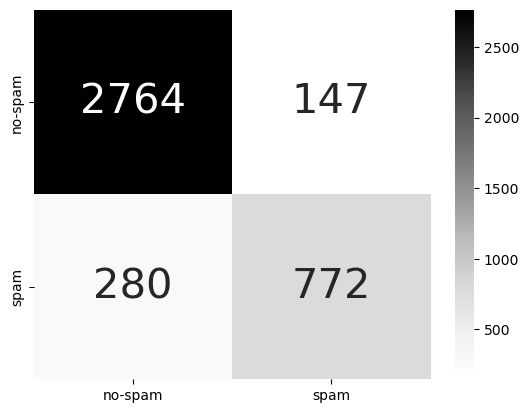

In [15]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [16]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7468 - Train F1-score: 0.5828 - Train Loss: 0.8221
Valid Accuracy: 0.8376 - Valid F1-score: 0.6314 - Valid Loss: 0.6935
Validation loss decreased (inf --> 0.693508). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8479 - Train F1-score: 0.7070 - Train Loss: 0.5826
Valid Accuracy: 0.8351 - Valid F1-score: 0.6645 - Valid Loss: 0.7500
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8826 - Train F1-score: 0.7617 - Train Loss: 0.4917
Valid Accuracy: 0.8785 - Valid F1-score: 0.6581 - Valid Loss: 0.9435
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9086 - Train F1-score: 0.8107 - Train Loss: 0.4334
Valid Accuracy: 0.8848 - Valid F1-score: 0.6929 - Valid Loss: 0.9800
EarlyStopping counter: 3 out of 3
Early stopping.


In [17]:
save_visualization_history(history, 'PhoBERT', task=2)
plotting_history(history)


In [18]:
import os
import torch

model_name = "PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8779
Precision: 0.7185
Recall: 0.7142
F1-score: 0.7156
Confusion matrix:
 [[2700   21  105   85]
 [  16   31    0    7]
 [ 147    0  151   11]
 [  72    5   15  597]]
              precision    recall  f1-score   support

           0     0.9199    0.9275    0.9237      2911
           1     0.5439    0.5741    0.5586        54
           2     0.5572    0.4887    0.5207       309
           3     0.8529    0.8665    0.8596       689

    accuracy                         0.8779      3963
   macro avg     0.7185    0.7142    0.7156      3963
weighted avg     0.8749    0.8779    0.8762      3963



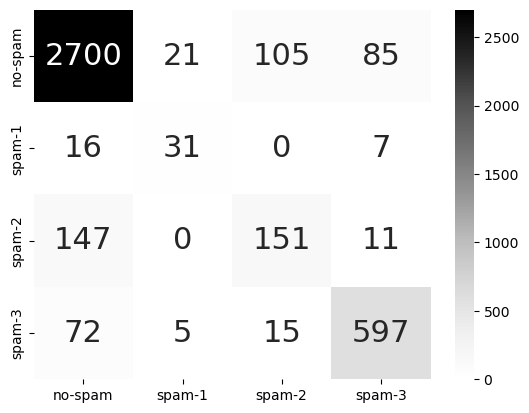

In [19]:
plotting_confusion_matrix(test_cm, task=2)


# BERT4News

In [20]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

def encode_data(examples):
    return tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


## Task 1

In [22]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8432 - Train F1-score: 0.8064 - Train Loss: 0.3952
Valid Accuracy: 0.8678 - Valid F1-score: 0.8338 - Valid Loss: 0.3706
Validation loss decreased (inf --> 0.370637). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9079 - Train F1-score: 0.8836 - Train Loss: 0.2765
Valid Accuracy: 0.8578 - Valid F1-score: 0.8274 - Valid Loss: 0.3663
Validation loss decreased (0.370637 --> 0.366313). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9470 - Train F1-score: 0.9320 - Train Loss: 0.2020
Valid Accuracy: 0.8792 - Valid F1-score: 0.8420 - Valid Loss: 0.5577
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9698 - Train F1-score: 0.9613 - Train Loss: 0.1337
Valid Accuracy: 0.8767 - Valid F1-score: 0.8417 - Valid Loss: 0.6902
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9782 - Train F1-score: 0.9721 - Train Loss: 0.1011
Valid Accuracy: 0.8861 - Valid F1-score: 0.8484 - Valid Loss: 0.7091
EarlyStopping counter: 3 out of 3
Early stopping.


In [23]:
save_visualization_history(history, 'BERT4News', task=1)
plotting_history(history)


In [24]:
import os
import torch

model_name = "BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8847
Precision: 0.8532
Recall: 0.8496
F1-score: 0.8514
Confusion matrix:
 [[2691  220]
 [ 237  815]]
              precision    recall  f1-score   support

           0     0.9191    0.9244    0.9217      2911
           1     0.7874    0.7747    0.7810      1052

    accuracy                         0.8847      3963
   macro avg     0.8532    0.8496    0.8514      3963
weighted avg     0.8841    0.8847    0.8844      3963



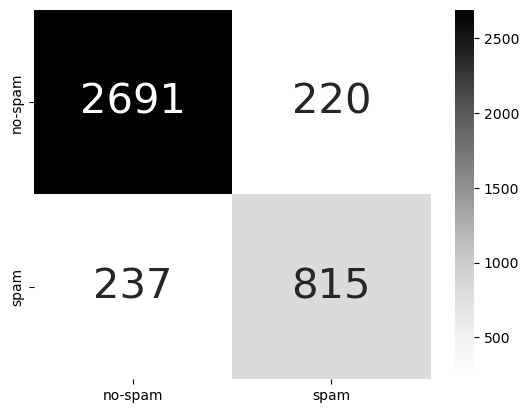

In [25]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [26]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="BERT4News", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7987 - Train F1-score: 0.6370 - Train Loss: 0.7392
Valid Accuracy: 0.8704 - Valid F1-score: 0.6768 - Valid Loss: 0.8323
Validation loss decreased (inf --> 0.832332). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8849 - Train F1-score: 0.7622 - Train Loss: 0.5313
Valid Accuracy: 0.8748 - Valid F1-score: 0.6446 - Valid Loss: 0.8719
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9240 - Train F1-score: 0.8262 - Train Loss: 0.3998
Valid Accuracy: 0.8861 - Valid F1-score: 0.6537 - Valid Loss: 1.1473
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9530 - Train F1-score: 0.8891 - Train Loss: 0.2831
Valid Accuracy: 0.8823 - Valid F1-score: 0.6551 - Valid Loss: 1.3727
EarlyStopping counter: 3 out of 3
Early stopping.


In [27]:
save_visualization_history(history, 'BERT4News', task=2)
plotting_history(history)


In [28]:
import os
import torch

model_name = "BERT4News"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8822
Precision: 0.7618
Recall: 0.6968
F1-score: 0.7255
Confusion matrix:
 [[2769   13   75   54]
 [  16   31    1    6]
 [ 162    0  141    6]
 [ 113    4   17  555]]
              precision    recall  f1-score   support

           0     0.9049    0.9512    0.9275      2911
           1     0.6458    0.5741    0.6078        54
           2     0.6026    0.4563    0.5193       309
           3     0.8937    0.8055    0.8473       689

    accuracy                         0.8822      3963
   macro avg     0.7618    0.6968    0.7255      3963
weighted avg     0.8759    0.8822    0.8774      3963



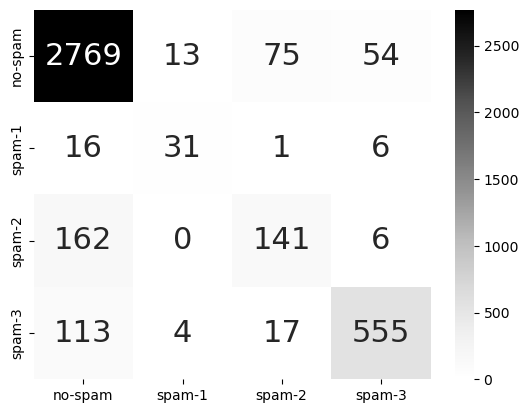

In [29]:
plotting_confusion_matrix(test_cm, task=2)


# ViBERT

In [30]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("FPTAI/vibert-base-cased")

def encode_data(examples):
    return tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


## Task 1

In [32]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 10
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8338 - Train F1-score: 0.7921 - Train Loss: 0.4297
Valid Accuracy: 0.8477 - Valid F1-score: 0.8068 - Valid Loss: 0.3846
Validation loss decreased (inf --> 0.384636). Saving model ...
Epoch 2/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8976 - Train F1-score: 0.8702 - Train Loss: 0.3108
Valid Accuracy: 0.8741 - Valid F1-score: 0.8201 - Valid Loss: 0.5561
EarlyStopping counter: 1 out of 3
Epoch 3/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9338 - Train F1-score: 0.9150 - Train Loss: 0.2433
Valid Accuracy: 0.8792 - Valid F1-score: 0.8375 - Valid Loss: 0.5475
EarlyStopping counter: 2 out of 3
Epoch 4/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9611 - Train F1-score: 0.9500 - Train Loss: 0.1729
Valid Accuracy: 0.8785 - Valid F1-score: 0.8333 - Valid Loss: 0.7334
EarlyStopping counter: 3 out of 3
Early stopping.


In [33]:
save_visualization_history(history, 'ViBERT', task=1)
plotting_history(history)


In [34]:
import os
import torch

model_name = "ViBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8766
Precision: 0.8485
Recall: 0.8274
F1-score: 0.8370
Confusion matrix:
 [[2714  197]
 [ 292  760]]
              precision    recall  f1-score   support

           0     0.9029    0.9323    0.9174      2911
           1     0.7941    0.7224    0.7566      1052

    accuracy                         0.8766      3963
   macro avg     0.8485    0.8274    0.8370      3963
weighted avg     0.8740    0.8766    0.8747      3963



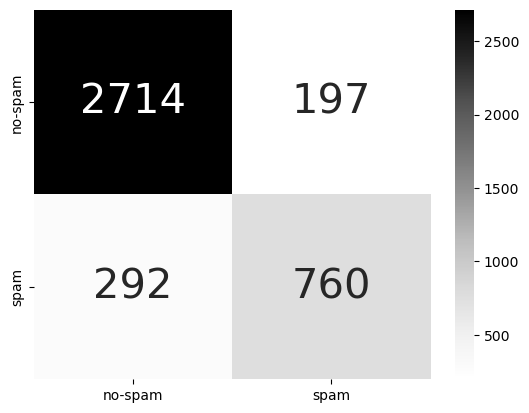

In [35]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [36]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="ViBERT", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 10
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7621 - Train F1-score: 0.5910 - Train Loss: 0.8143
Valid Accuracy: 0.8584 - Valid F1-score: 0.6409 - Valid Loss: 0.9119
Validation loss decreased (inf --> 0.911853). Saving model ...
Epoch 2/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8622 - Train F1-score: 0.7252 - Train Loss: 0.5891
Valid Accuracy: 0.8628 - Valid F1-score: 0.6388 - Valid Loss: 0.9686
EarlyStopping counter: 1 out of 3
Epoch 3/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9112 - Train F1-score: 0.8069 - Train Loss: 0.4446
Valid Accuracy: 0.8357 - Valid F1-score: 0.6251 - Valid Loss: 0.8117
Validation loss decreased (0.911853 --> 0.811723). Saving model ...
Epoch 4/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9454 - Train F1-score: 0.8778 - Train Loss: 0.3176
Valid Accuracy: 0.8634 - Valid F1-score: 0.6604 - Valid Loss: 1.2290
EarlyStopping counter: 1 out of 3
Epoch 5/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9630 - Train F1-score: 0.9152 - Train Loss: 0.2251
Valid Accuracy: 0.8735 - Valid F1-score: 0.6391 - Valid Loss: 1.8826
EarlyStopping counter: 2 out of 3
Epoch 6/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9754 - Train F1-score: 0.9417 - Train Loss: 0.1514
Valid Accuracy: 0.8748 - Valid F1-score: 0.6144 - Valid Loss: 2.1876
EarlyStopping counter: 3 out of 3
Early stopping.


In [37]:
save_visualization_history(history, 'ViBERT', task=2)
plotting_history(history)


In [38]:
import os
import torch

model_name = "ViBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8736
Precision: 0.7770
Recall: 0.6425
F1-score: 0.6925
Confusion matrix:
 [[2761    6   84   60]
 [  25   22    1    6]
 [ 169    1  128   11]
 [ 129    0    9  551]]
              precision    recall  f1-score   support

           0     0.8953    0.9485    0.9211      2911
           1     0.7586    0.4074    0.5301        54
           2     0.5766    0.4142    0.4821       309
           3     0.8774    0.7997    0.8368       689

    accuracy                         0.8736      3963
   macro avg     0.7770    0.6425    0.6925      3963
weighted avg     0.8654    0.8736    0.8669      3963



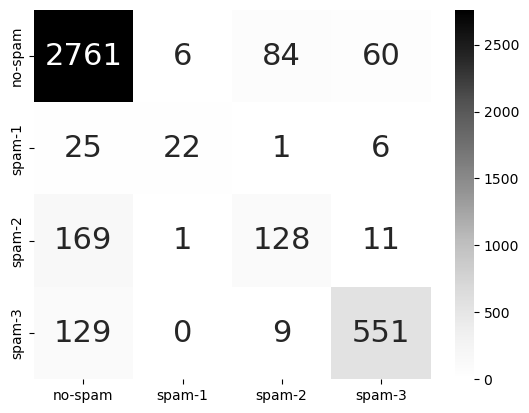

In [39]:
plotting_confusion_matrix(test_cm, task=2)
